In [1]:
# from pygdsm import GlobalSkyModel2016
from pygdsm import LowFrequencySkyModel, LFSMObserver
import healpy as hp
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

In [ ]:
k=1.38e-23
c=3e8
nu=74e6
#

In [10]:
# (latitude, longitude, elevation) = ('51.4641932', '-68.2348603', 336.499)
(latitude, longitude, elevation) = (79+25.031/60, -90-46.041/60, 189)
ov = LFSMObserver()
ov.lon = longitude
ov.lat = latitude
ov.elev = elevation
ov.date = datetime(2024, 11, 12, 2, 59)
map1=ov.generate(20)

In [469]:
freqs = np.linspace(20,100,200)
brightness = np.zeros(len(freqs))
for i,f in enumerate(freqs):
    brightness[i] = np.ma.mean(ov.generate(freqs[i]))
    

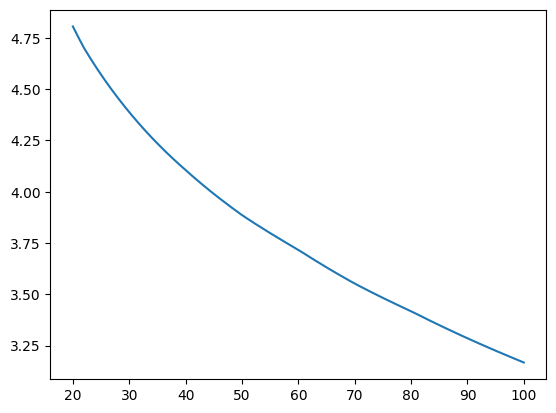

In [470]:
plt.plot(freqs,np.log10(brightness))

In [471]:
np.savez("brightness.npz",freqs=freqs,brightness=brightness)

In [25]:
gsm=LowFrequencySkyModel()
map2=gsm.generate(20)

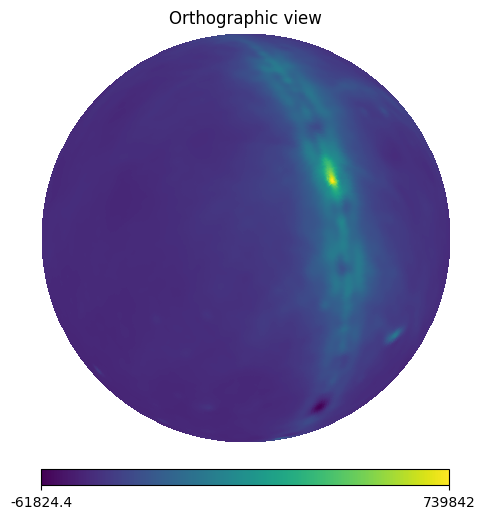

In [7]:
map1=ov.view(logged=False)
plt.show()

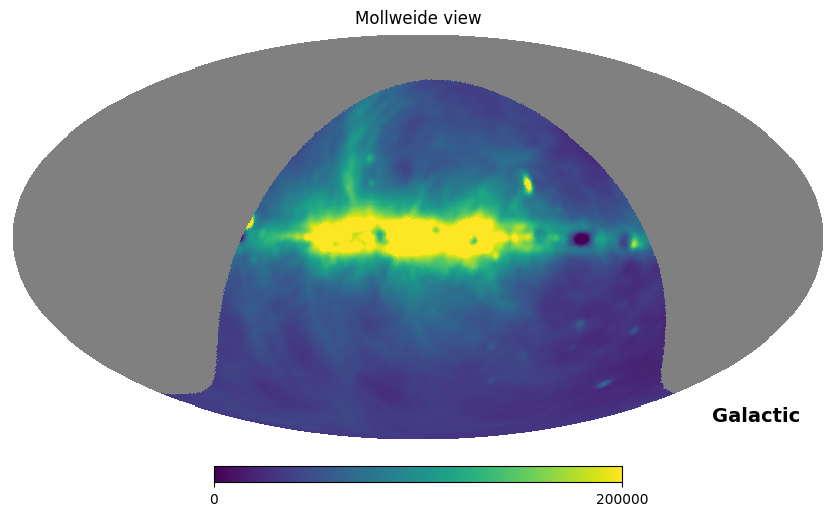

In [23]:
ov.view_observed_gsm(logged=False,max=200000,min=0)
plt.show()

/tmp/ipykernel_2826151/3021877318.py:1: RuntimeWarning: invalid value encountered in log10
  hp.mollview(np.log10(map2),cmap='inferno')


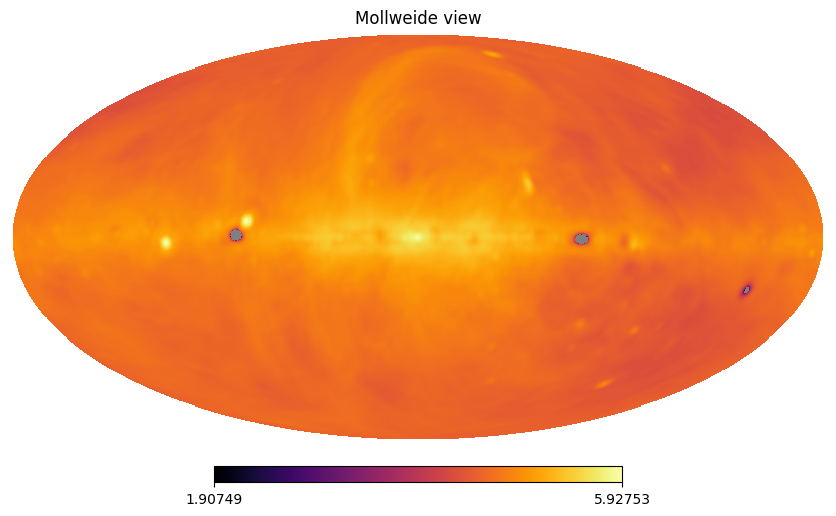

In [27]:
hp.mollview(np.log10(map2),cmap='inferno')

In [32]:
alms=hp.sphtfunc.map2alm(map2,gal_cut=15)

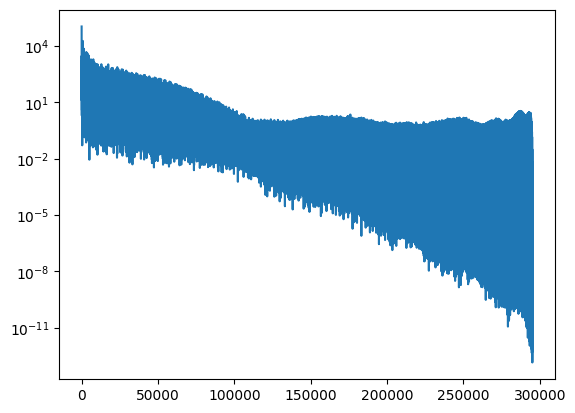

In [36]:
plt.semilogy(np.abs(alms))

In [42]:
lmax=3*256-1
print(lmax*(lmax+1)/2+lmax + 1)

295296.0


In [57]:
m=500
indices=[((l * (l + 1)) // 2 + m) for l in range(m, lmax + 1)]
indices2=np.arange(m,lmax+1)
indices2=indices2+indices2*(indices2-1)//2 + m
print(indices2[:10])

[125750 126251 126753 127256 127760 128265 128771 129278 129786 130295]


In [58]:
np.sum(indices-indices2)

np.int64(0)

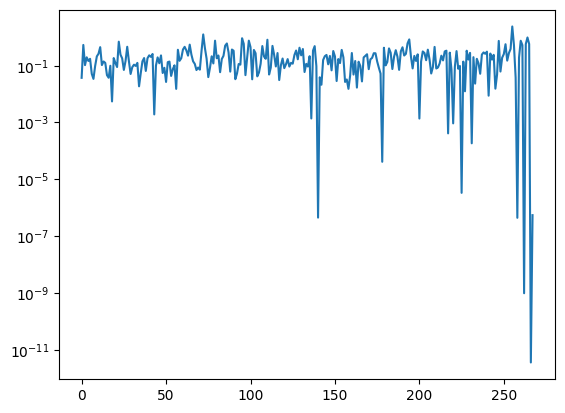

In [59]:
plt.semilogy(np.abs(alms[indices]))

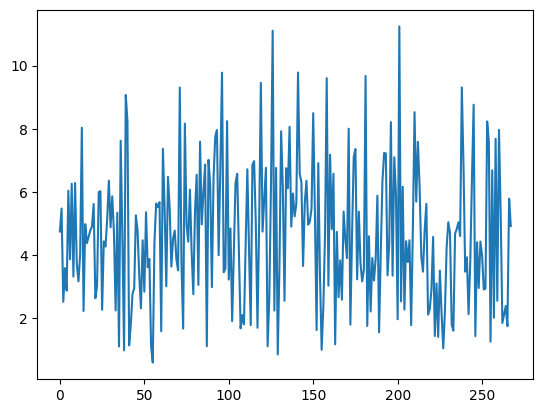

In [60]:
plt.plot(np.abs(np.fft.fft(alms[indices])))

In [432]:
npix=hp.get_map_size(map2)
nside=hp.npix2nside(npix)
tht,phi=hp.pix2ang(nside, np.arange(0,npix))

In [91]:
rot = hp.Rotator(coord=['G', 'C'])
g0,g1 = rot(tht,phi)

In [92]:
newpix=hp.ang2pix(nside,g0,g1)

In [451]:
map2new=map2[newpix].copy()

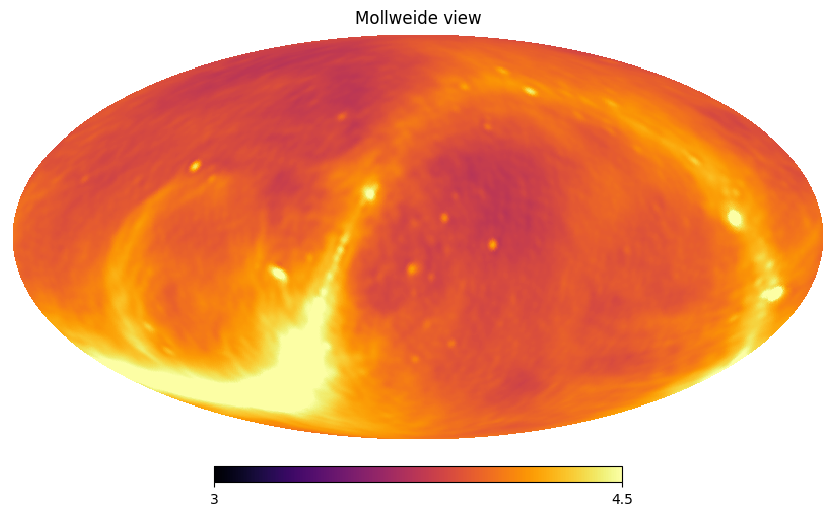

In [380]:
hp.mollview(np.log10(map2new),min=3,max=4.5,cmap='inferno')

In [95]:
mask=np.zeros(npix,dtype="int")

In [96]:
mask = phi>np.pi

In [97]:
masked_map2new=hp.ma(map2new)

In [98]:
masked_map2new.mask=mask

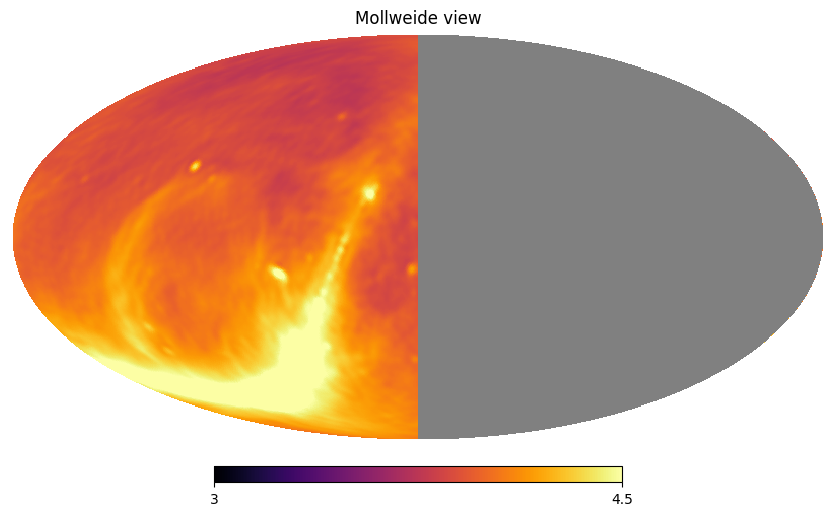

In [99]:
hp.mollview(np.log10(masked_map2new),min=3,max=4.5,cmap='inferno')

In [378]:
def hadec2altaz(ha,dec,lat):
    ha,dec,lat=list(map(np.deg2rad,[ha,dec,lat]))
    alt = np.arcsin(np.sin(dec)*np.sin(lat) + np.cos(dec)*np.cos(lat)*np.cos(ha))
#     az1 = np.arccos((np.sin(dec)-np.sin(alt)*np.sin(lat))/(np.cos(alt)*np.cos(lat))
#     )
#     az = np.arccos((np.cos(lat)*np.sin(dec)-np.sin(lat)*np.cos(dec)*np.cos(ha))/np.cos(alt)
#     )
    az3 = (np.arctan2(np.sin(ha), np.cos(ha)*np.sin(lat) - np.tan(dec)*np.cos(lat)))
    az3-=np.pi
    az3=az3%(2*np.pi)
#     print(np.max(np.abs(az-az3)))
    return np.rad2deg(alt),np.rad2deg(az3)

In [106]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from astropy.time import Time

In [433]:
myra = (phi + 2*np.pi) % (2*np.pi)
mydec = (np.pi/2-tht)
c_icrs = SkyCoord(ra=myra*u.rad,dec=mydec*u.rad,frame="icrs")

In [447]:
uapishka = EarthLocation(lat=51.4641932*u.deg,lon=-68.2348603*u.deg,height=336.499*u.m)
mytime = Time('2023-7-12 02:59:40',location=uapishka) #utc
c_altaz = c_icrs.transform_to(AltAz(obstime=mytime,location=uapishka))
LST=mytime.sidereal_time("apparent")
print(LST.hour)


17.762552642204877


In [440]:
zenith=SkyCoord(alt=90*u.deg,az=0*u.deg,frame="altaz",obstime=mytime,location=uapishka)
zenith_radec = zenith.transform_to("icrs")
zenith_radec.ra.hour #equals LST at the given time above
dec_zen=zenith_radec.dec.deg
ra_zen=zenith_radec.ra.deg
dec=np.rad2deg(mydec)
ra=np.rad2deg(myra)
print(ra_zen,dec_zen)

266.29336278330476 51.47261131406671


In [442]:
dist = 2 * np.arcsin( np.sqrt( np.sin((dec_zen-dec)*(np.pi/180)/2)**2 + \
                    np.cos(dec_zen*(np.pi/180))*np.cos(dec*(np.pi/180))*np.sin((ra_zen-ra)*(np.pi/180)/2)**2 ) )
mask = dist > (np.pi/2)

In [379]:
hadec2altaz(0,40+44/60,51.4641932) #cyg A alt az

(79.26914013333341, 180.0)

In [381]:
hadec2altaz(0,-28-56/60,51.4641932) #gal centre alt az

(9.602473466666664, 180.0)

In [247]:
print(c_icrs.ra.deg[10000],c_icrs.dec.deg[10000])

76.69014084507042 76.99747443153808


In [360]:
90-51.4641932

38.5358068

In [280]:
HA=LST.deg-c_icrs.ra.deg
print(np.where(HA<0))
HA=HA%360
print(np.where(HA<0))

(array([     3,     10,     11, ..., 786426, 786427, 786431]),)
(array([], dtype=int64),)


In [344]:
alt2,az2=hadec2altaz(HA,c_icrs.dec.deg,51.4641932)
# az2+=180
# az2=az2%360

In [345]:
idx=50000
print(c_icrs.ra.hour[idx],c_icrs.dec.deg[idx])
print(alt2[idx],az2[idx])
print(c_altaz.alt[idx].deg,c_altaz.az[idx].deg)
print(LST)

14.753164556962028 60.8122696032311
56.588880824983214 309.9055364018435
56.64350128311237 309.71058406492114
18h45m14.93659347s


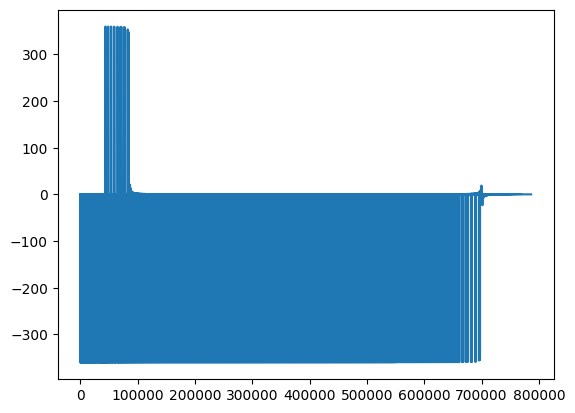

In [346]:
diff=(az2-c_altaz.az.deg)
# diff-=360
# diff=diff%360
plt.plot(diff)
# plt.xlim(0,100)
# plt.xlim(43974-10,43974+10)
# np.where((az2-c_altaz.az.deg)>1)

In [347]:
diff[0:10]

array([ 1.97026185e-01,  1.97013608e-01,  1.95936436e-01, -3.59804053e+02,
        1.97089566e-01,  1.97888104e-01,  1.97873139e-01,  1.97056480e-01,
        1.95892147e-01,  1.95058385e-01])

In [349]:
np.min(c_altaz.alt.deg)

-89.94004867249654

In [288]:
np.max(az2%360)

359.9996465381319

In [223]:
print(c_altaz.alt.deg[10000],c_altaz.az.deg[10000])

39.366047871299045 6.7289196993237175


In [448]:
mymask = c_altaz.alt.deg<0

In [452]:
masked_map2new=hp.ma(map2new)
masked_map2new.mask=mask

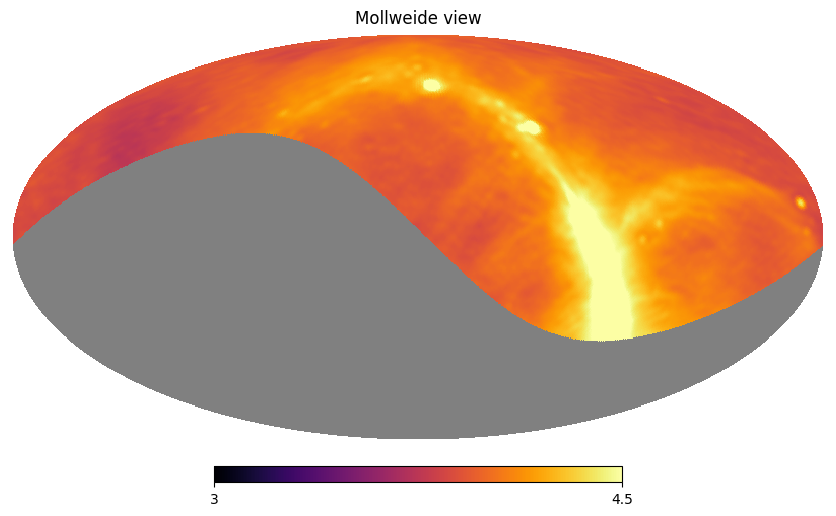

In [453]:
hp.mollview(np.log10(masked_map2new),min=3,max=4.5,cmap='inferno')

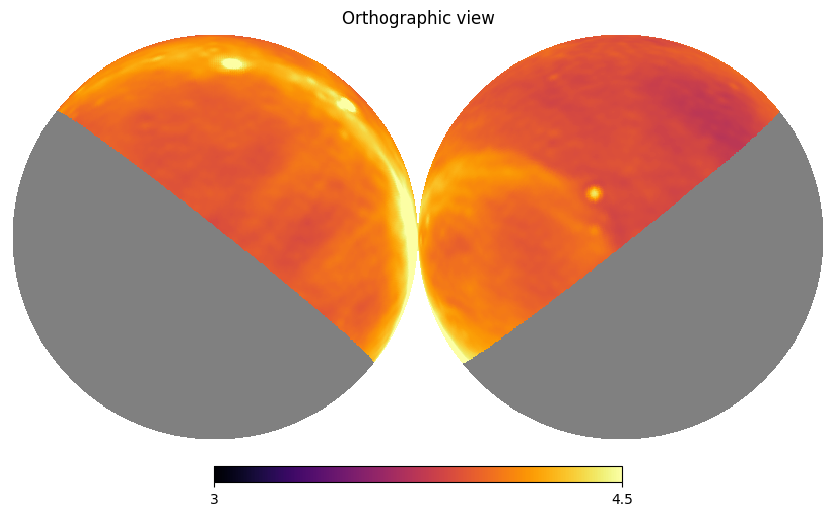

In [463]:
masked_map2new=hp.ma(map2new)
masked_map2new.mask=mymask
hp.orthview(np.log10(masked_map2new),min=3,max=4.5,cmap='inferno')

In [450]:
np.where(mask!=mymask)

(array([161457, 175765, 229265, 252487, 301607, 313290, 363013, 392694,
        394230, 422917, 473546, 484391, 533575, 567394, 610453, 624817]),)

In [457]:
rot = hp.Rotator(coord=['C', 'G'])
g0,g1 = rot(tht,phi)
newpix=hp.ang2pix(nside,g0,g1)
map3=masked_map2new[newpix].copy()

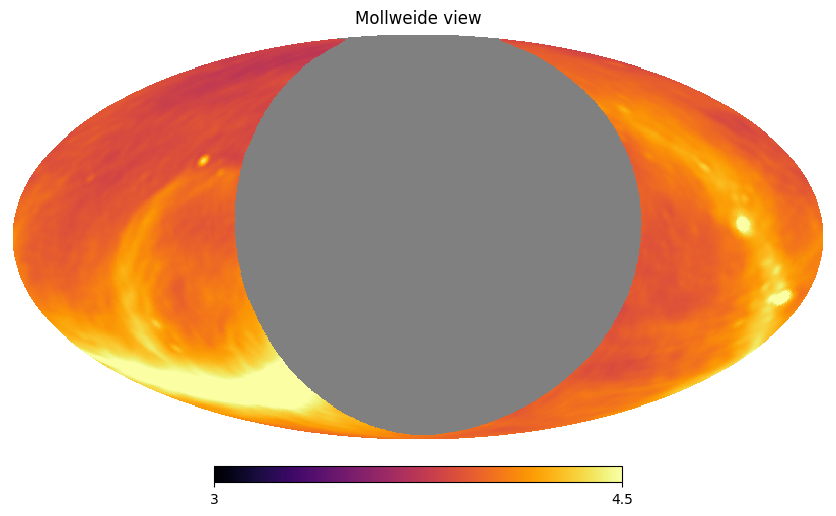

In [458]:
hp.mollview(np.log10(map3),min=3,max=4.5,cmap='inferno')